<h1>Aplicatie pentru a detecta daca un mesaj este spam sau nu</h1>

Pentru implementarea acesteia vom folosi 2 metode. 
Clasificator binar folosind CMMP.
Clasificator folosind Support Vector Machine.

Scopul aplicatiei este de a realiza o comparatie intre cele 2 si sa observam care dintre ele este cel mai probabil sa isi dea seama de tipul mail-ului.

In [2]:
# Importarea bibliotecilor pe care le vom folosi
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer
import wordcloud as wc
from matplotlib.colors import ListedColormap

In [3]:
# Citirea fisierului cu mail-uri de intrare
data = pd.read_csv('spam.csv', encoding = 'latin-1')

# Eliminarea coloanelor de care nu este nevoie in fisier
data = data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)

# Redenumirea coloanelor pentru a le putea folosi mai usor in label si message
data.columns = ['label', 'message']

# Inlocuirea lui ham cu 1 si spam cu -1
data['label'] = data['label'].map({'ham': 1, 'spam': -1})

messages = data['message']
messages = messages.to_list()
labels = data['label']

<h1>Crearea a doua word clouds</h1>
<p>Primul va contine cuvintele dominante in mesajele bune</p>
<p>Al doilea va contine cuvintele dominante in mesajele spam</p>

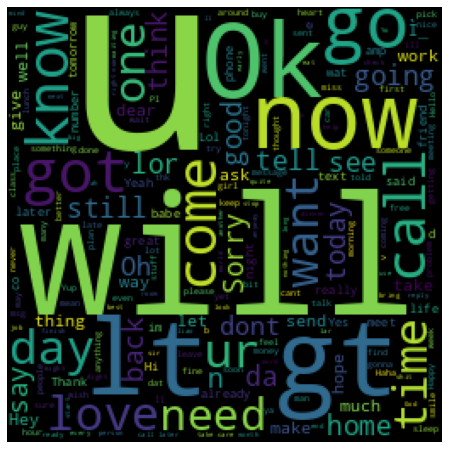

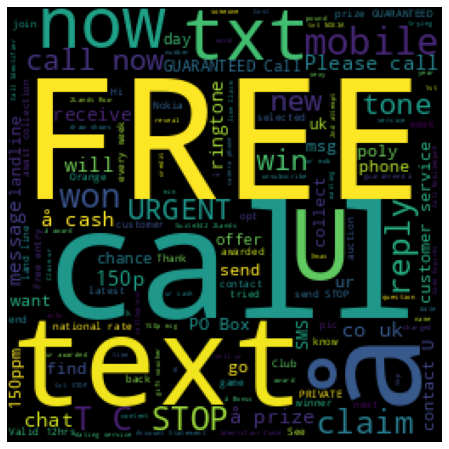

In [4]:
hamWords = ''
spamWords = ''

for val in data[data['label'] == 1]['message']:
    hamWords += val + ' '

for val in data[data['label'] == -1]['message']:
    spamWords += val + ' '

hamWordCloud = wc.WordCloud(background_color = 'black', width = 256, height = 256).generate(hamWords)
spamWordCloud = wc.WordCloud(background_color = 'black', width = 256, height = 256).generate(spamWords)

# Desenez cele doua wordcloud-uri
plt.figure(figsize = (10, 8))
plt.imshow(hamWordCloud)
plt.axis('off')
plt.show()

plt.figure(figsize = (10, 8))
plt.imshow(spamWordCloud)
plt.axis('off')
plt.show()

<h1>Preprocesarea mesajelor</h1>
<p>In aceasta etapa se vor elimina toate semnele de punctuatie din mesaje si toate cuvintele vor fi transformate in lowercase.</p>

In [5]:
# Eliminarea punctuatiei din fiecare mesaj
for i in range(len(messages)):
    messages[i] = messages[i].lower()
    messages[i] = re.sub(r'\W', ' ', messages[i])
    messages[i] = re.sub(r'\s+', ' ', messages[i])


In [6]:
# Bag of words

countVec = CountVectorizer(ngram_range=(1, 1), stop_words = 'english')
countData = countVec.fit_transform(messages[ : 4000])

# Creez dataframe
dataFrame = pd.DataFrame(countData.toarray(), columns = countVec.get_feature_names_out())
print(dataFrame)

      00  000  000pes  008704050406  0089  01223585236  01223585334  \
0      0    0       0             0     0            0            0   
1      0    0       0             0     0            0            0   
2      0    0       0             0     0            0            0   
3      0    0       0             0     0            0            0   
4      0    0       0             0     0            0            0   
...   ..  ...     ...           ...   ...          ...          ...   
3995   0    0       0             0     0            0            0   
3996   0    0       0             0     0            0            0   
3997   0    0       0             0     0            0            0   
3998   0    0       0             0     0            0            0   
3999   0    0       0             0     0            0            0   

      0125698789  02  0207  ...  ì_  ì¼1  ìï  û_  ûªm  ûªt  ûªve  ûï  ûïharry  \
0              0   0     0  ...   0    0   0   0    0    0     0  

<h3>Rezolvam sistemul de tip Ax = b folosind CMMP.</h3>

In [7]:
# Rezolvarea folosind functia din numpy
data = countData.toarray()
n, m = data.shape # n = numarul de linii, m = numarul de coloane

# adaug o coloana plina de 1 la finalul matricei
data = np.append(data, np.ones((n, 1)), axis = 1)
trainLabels = labels[ : 4000]
leastSquareSol = np.linalg.lstsq(data, trainLabels, rcond = None)[0]

<h1>Un grafic care arata cate mesaje au fost bune si cate au fost spam</h1>
<p>Cele care au fost bune sunt marcate cu verde, iar cele care au fost spam cu rosu.</p>
<p>Datorita timpilor de rulare foarte mari, am decis sa folosim decat primele 500 de mesaje din datele de antrenament</p>

The ratio between positive and negative points is: 27%


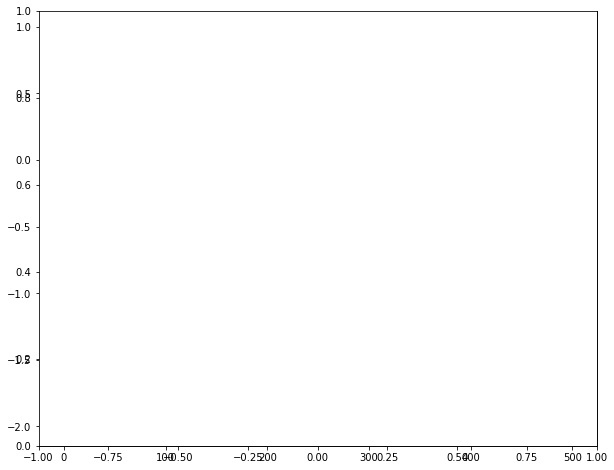

In [13]:
positive = 0
negative = 0

plt.figure(figsize = (10, 8))
for i in range(500):
    if (leastSquareSol[i] > 0):
        plt.scatter(i, leastSquareSol[i], color = 'green')
        positive += 1
    else:
        plt.scatter(i, leastSquareSol[i], color = 'red')
        negative += 1

print('The ratio between positive and negative points is: ' + str(int(positive / (positive + negative) * 100)) + '%')
plt.show()

<h3>Etapa de testare</h3>
<p>In aceasta etapa vom folosi restul mailurilor ramase in datele citite si vom alege din ele pentru a testa daca mail-ul este spam sau ham.</p>

In [9]:
testData = messages[4001 : ]

id =  int(input("Introduceti o valoare a unui mesaj din vector: "))
print(testData[id])

im fine babes aint been up 2 much tho saw scary movie yest its quite funny want 2mrw afternoon at town or mall or sumthin xx


<h3>Testarea clasificatorului</h3> 
<p>Aceasta etapa va prezice testLabel iar in functie de valoarea acestuia, vom determina daca un mesaj este spam sau ham.<p>
<p>Daca testLabel o sa fie -1 atunci mesajul este spam, daca este 1 atunci este ham<p>   

In [10]:
# Transformarea mesajului intr-un vector de numere
sentence = testData[id]
sentence = sentence.lower()
sentence = re.sub(r'\W', ' ', sentence)
sentence = re.sub(r'\s+', ' ', sentence)

# Transformarea mesajului intr-un vector de numere
sentence = countVec.transform([sentence])
sentence = sentence.toarray()

# Predict the label
sentence = np.append(sentence, np.ones((1, 1)), axis = 1)
prediction = np.dot(sentence, leastSquareSol)

if (prediction > 0):
    print("Mesajul " + testData[id] + " nu este spam")
else:
    print("Mesajul este spam")



(7039,)
Mesajul im fine babes aint been up 2 much tho saw scary movie yest its quite funny want 2mrw afternoon at town or mall or sumthin xx nu este spam
